In [23]:
print("Example of running a git command:")
!git status

Example of running a git command:
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [24]:
!git clone https://github.com/dhanukkrishna/3D_Data_Classification.git
%cd 3D_Data_Classification

Cloning into '3D_Data_Classification'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 8.25 KiB | 8.25 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/Source Coe/Source Coe/3D_Data_Classification


In [26]:
!cp "/content/drive/MyDrive/Colab Notebooks/Dec_10_model_norm.ipynb"

cp: missing destination file operand after '/content/drive/MyDrive/Colab Notebooks/Dec_10_model_norm.ipynb'
Try 'cp --help' for more information.


In [25]:
#pushing to github
!git commit -m "first commit"
!git push origin main

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


### **Mounting Drive**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm

# **Define PointNet++ sampling +Grouping**

In [ ]:
def square_distance(src, dst):
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).unsqueeze(-1)
    dist += torch.sum(dst ** 2, -1).unsqueeze(1)
    return dist

def index_points(points, idx):
    device = points.device
    B = points.shape[0]
    new_shape = list(idx.shape)
    idx_flat = idx.reshape(B, -1)
    batch_indices = torch.arange(B, device=device).view(B, 1).repeat(1, idx_flat.shape[1])
    result = points[batch_indices, idx_flat]
    return result.reshape(*new_shape, points.shape[-1])

def farthest_point_sample(xyz, npoint):
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long, device=device)
    distance  = torch.ones(B, N, device=device) * 1e10
    farthest = torch.randint(0, N, (B,), device=device)
    batch_indices = torch.arange(B, device=device)

    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest].unsqueeze(1)
        dist = torch.sum((xyz - centroid)**2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]

    return centroids

def query_ball_point(radius, nsample, xyz, new_xyz):
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    sqrdists = square_distance(new_xyz, xyz)

    group_idx = torch.arange(N, device=device).view(1,1,N).repeat(B,S,1)
    group_idx[sqrdists > radius**2] = N

    group_idx = group_idx.sort(dim=-1)[0][:,:,:nsample]

    first = group_idx[:,:,0].unsqueeze(-1).repeat(1,1,nsample)
    mask = group_idx == N
    group_idx[mask] = first[mask]

    return group_idx

def sample_and_group(npoint, radius, nsample, xyz, points):
    B, N, C = xyz.shape
    fps_idx = farthest_point_sample(xyz, npoint)
    new_xyz = index_points(xyz, fps_idx)
    idx = query_ball_point(radius, nsample, xyz, new_xyz)

    grouped_xyz = index_points(xyz, idx)
    grouped_xyz_norm = grouped_xyz - new_xyz.unsqueeze(2)

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1)
    else:
        new_points = grouped_xyz_norm

    return new_xyz, new_points

def sample_and_group_all(xyz, points):
    B, N, C = xyz.shape
    new_xyz = torch.zeros(B,1,C).to(xyz.device)
    new_points = xyz.view(B,1,N,C)
    if points is not None:
        new_points = torch.cat([new_points, points.view(B,1,N,-1)], dim=-1)
    return new_xyz, new_points

In [ ]:
class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super().__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.group_all = group_all
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns   = nn.ModuleList()

        last = in_channel
        for out in mlp:
            self.mlp_convs.append(nn.Conv2d(last, out, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out))
            last = out

    def forward(self, xyz, points):
        xyz = xyz.permute(0,2,1)
        if points is not None:
            points = points.permute(0,2,1)

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)

        new_points = new_points.permute(0,3,2,1)
        for conv, bn in zip(self.mlp_convs, self.mlp_bns):
            new_points = F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points,2)[0]
        new_xyz = new_xyz.permute(0,2,1)
        return new_xyz, new_points

class PointNetSetAbstractionMsg(nn.Module):
    def __init__(self, npoint, radius_list, nsample_list, in_channel, mlp_list):
        super().__init__()
        self.npoint = npoint
        self.radius_list = radius_list
        self.nsample_list = nsample_list

        self.conv_blocks = nn.ModuleList()
        self.bn_blocks   = nn.ModuleList()

        for mlp in mlp_list:
            convs = nn.ModuleList()
            bns   = nn.ModuleList()
            last = in_channel + 3
            for out in mlp:
                convs.append(nn.Conv2d(last, out, 1))
                bns.append(nn.BatchNorm2d(out))
                last = out
            self.conv_blocks.append(convs)
            self.bn_blocks.append(bns)

    def forward(self, xyz, points):
        xyz = xyz.permute(0,2,1)
        if points is not None:
            points = points.permute(0,2,1)

        B,N,C = xyz.shape
        S = self.npoint
        new_xyz = index_points(xyz, farthest_point_sample(xyz,S))

        new_points_list = []
        for i,radius in enumerate(self.radius_list):
            K = self.nsample_list[i]
            idx = query_ball_point(radius, K, xyz, new_xyz)
            grouped_xyz = index_points(xyz, idx)
            grouped_xyz -= new_xyz.unsqueeze(2)

            if points is not None:
                grouped_points = index_points(points, idx)
                grouped_points = torch.cat([grouped_points, grouped_xyz], -1)
            else:
                grouped_points = grouped_xyz

            grouped_points = grouped_points.permute(0,3,2,1)

            for conv, bn in zip(self.conv_blocks[i], self.bn_blocks[i]):
                grouped_points = F.relu(bn(conv(grouped_points)))

            # Corrected line: apply max pooling to grouped_points
            new_points_agg = torch.max(grouped_points,2)[0]
            new_points_list.append(new_points_agg)

        new_xyz = new_xyz.permute(0,2,1)
        return new_xyz, torch.cat(new_points_list, 1)

## **Model pointnet++ classification MSG**

In [ ]:
class get_model(nn.Module):
    def __init__(self, num_class, normal_channel=True):
        super().__init__()
        in_channel = 3 if normal_channel else 0
        self.normal_channel = normal_channel

        self.sa1 = PointNetSetAbstractionMsg(
            512, [0.1,0.2,0.4], [16,32,128], in_channel,
            [[32,32,64],[64,64,128],[64,96,128]]
        )
        self.sa2 = PointNetSetAbstractionMsg(
            128, [0.2,0.4,0.8], [32,64,128], 320,
            [[64,64,128],[128,128,256],[128,128,256]]
        )
        self.sa3 = PointNetSetAbstraction(
            None, None, None, 640+3, [256,512,1024], True
        )

        self.fc1 = nn.Linear(1024,512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(512,256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256,num_class)

    def forward(self, x):
        B = x.size(0)

        if self.normal_channel:
            norm = x[:,3:,:]
            xyz  = x[:,:3,:]
        else:
            norm = None
            xyz  = x

        l1_xyz, l1_points = self.sa1(xyz, norm)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)

        x = l3_points.view(B,1024)
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x,-1), l3_points

class get_loss(nn.Module):
    def forward(self, pred, target, _=None):
        return F.nll_loss(pred, target)

In [ ]:
def pc_normalize(pc):
    centroid = pc.mean(axis=0)
    pc = pc - centroid
    m = np.max(np.linalg.norm(pc, axis=1))
    return pc / m

class ModelNetNPY_Split(Dataset):
    def __init__(self, file_list, labels, num_points=1024, use_normals=True):
        self.files = file_list
        self.labels = labels
        self.num_points = num_points
        self.use_normals = use_normals

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        pc = np.load(self.files[idx]).astype(np.float32)
        label = self.labels[idx]

        pc[:, :3] = pc_normalize(pc[:, :3])

        if pc.shape[0] >= self.num_points:
            choice = np.random.choice(pc.shape[0], self.num_points, replace=False)
        else:
            choice = np.random.choice(pc.shape[0], self.num_points, replace=True)

        pc = pc[choice]

        if not self.use_normals:
            pc = pc[:, :3]

        pc = torch.from_numpy(pc).float().transpose(0, 1)
        label = torch.tensor(label).long()

        return pc, label

In [ ]:
def create_splits(root, ratio=0.8):
    classes = sorted(os.listdir(root))
    class_to_idx = {cls: i for i, cls in enumerate(classes)}

    train_f = []
    val_f = []
    test_f = []

    train_l = []
    val_l = []
    test_l = []

    for cls in classes:
        label = class_to_idx[cls]

        train_dir = os.path.join(root, cls, "train")
        test_dir = os.path.join(root, cls, "test")

        # gather files
        train_list = [os.path.join(train_dir, f) for f in os.listdir(train_dir)
                      if f.endswith('.npy')]
        random.shuffle(train_list)

        split_idx = int(len(train_list) * ratio)

        # train
        train_f += train_list[:split_idx]
        train_l += [label] * split_idx

        # val
        val_f += train_list[split_idx:]
        val_l += [label] * (len(train_list) - split_idx)

        # test
        test_list = [os.path.join(test_dir, f) for f in os.listdir(test_dir)
                     if f.endswith('.npy')]
        test_f += test_list
        test_l += [label] * len(test_list)

    return (train_f, train_l), (val_f, val_l), (test_f, test_l)

In [ ]:
ROOT = "/content/drive/MyDrive/Colab Notebooks/ModelNet10_normals"

In [ ]:
(train_f, train_l), (val_f, val_l), (test_f, test_l) = create_splits(ROOT)

In [ ]:
train_ds = ModelNetNPY_Split(train_f, train_l, use_normals=False)
val_ds   = ModelNetNPY_Split(val_f, val_l, use_normals=False)
test_ds  = ModelNetNPY_Split(test_f, test_l, use_normals=False)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
num_classes = len(os.listdir(ROOT))
model = get_model(num_classes, normal_channel=False).to(DEVICE)

criterion = get_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0
history = []

In [ ]:
print("Number of classes:", num_classes)
print("Device:", DEVICE if DEVICE == "cuda" else "cpu")

Number of classes: 10
Device: cuda


In [ ]:
#Deleting the empty file
import os

folder_path = ROOT
# "/content/drive/MyDrive/Colab Notebooks/ModelNet10_normals"   # change path

deleted = 0

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)

        # Check file size
        if os.path.getsize(file_path) == 0:
            os.remove(file_path)
            print("Deleted empty file:", file_path)
            deleted += 1

print(f"\nTotal empty files deleted: {deleted}")



Total empty files deleted: 0


In [ ]:
for pc, labels in train_loader:
    print(".", end="")


........................................................................................................................................................................................................

In [ ]:
import numpy as np
import os

root = "/content/drive/MyDrive/Colab Notebooks/ModelNet10_normals"  # change

bad_files = []

for cls in os.listdir(root):
    class_path = os.path.join(root, cls)
    for split in ["train", "test", "val"]:
        split_path = os.path.join(class_path, split)
        if not os.path.exists(split_path):
            continue
        for f in os.listdir(split_path):
            fp = os.path.join(split_path, f)

            try:
                arr = np.load(fp)
                if arr.size == 0 or arr.ndim == 0:
                    print("Empty array:", fp)
                    bad_files.append(fp)
            except Exception as e:
                print("Corrupted file:", fp, "| Error:", e)
                bad_files.append(fp)

print("\nTotal corrupted files:", len(bad_files))



Total corrupted files: 0


In [ ]:
for f in bad_files:
    os.remove(f)
    print("Deleted:", f)


In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for pc, labels in tqdm(train_loader):
        pc, labels = pc.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        pred, _ = model(pc)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (pred.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # ---------- Validation ----------
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():
        for pc, labels in val_loader:
            pc, labels = pc.to(DEVICE), labels.to(DEVICE)
            pred, _ = model(pc)
            loss = criterion(pred, labels)
            val_loss += loss.item()
            val_correct += (pred.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1} | Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/best_pointnet_normal.pth")
        best_val_acc = val_acc

    # Save history
    history.append({
        "epoch": epoch+1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

100%|██████████| 200/200 [02:15<00:00,  1.47it/s]


Epoch 1 | Train Acc=0.8913 | Val Acc=0.9175


100%|██████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch 2 | Train Acc=0.9110 | Val Acc=0.9400


100%|██████████| 200/200 [02:13<00:00,  1.49it/s]


Epoch 3 | Train Acc=0.9229 | Val Acc=0.9337


100%|██████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch 4 | Train Acc=0.9348 | Val Acc=0.9313


100%|██████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch 5 | Train Acc=0.9380 | Val Acc=0.9500


100%|██████████| 200/200 [02:13<00:00,  1.50it/s]


Epoch 6 | Train Acc=0.9386 | Val Acc=0.9525


100%|██████████| 200/200 [02:13<00:00,  1.50it/s]


Epoch 7 | Train Acc=0.9389 | Val Acc=0.8888


100%|██████████| 200/200 [02:13<00:00,  1.50it/s]


Epoch 8 | Train Acc=0.9436 | Val Acc=0.9587


100%|██████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch 9 | Train Acc=0.9470 | Val Acc=0.9300


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch 10 | Train Acc=0.9486 | Val Acc=0.9537


100%|██████████| 200/200 [02:14<00:00,  1.48it/s]


Epoch 11 | Train Acc=0.9495 | Val Acc=0.9500


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch 12 | Train Acc=0.9505 | Val Acc=0.9712


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch 13 | Train Acc=0.9561 | Val Acc=0.9487


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch 14 | Train Acc=0.9514 | Val Acc=0.9463


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch 15 | Train Acc=0.9583 | Val Acc=0.9663


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch 16 | Train Acc=0.9574 | Val Acc=0.9600


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch 17 | Train Acc=0.9624 | Val Acc=0.9400


100%|██████████| 200/200 [02:15<00:00,  1.47it/s]


Epoch 18 | Train Acc=0.9627 | Val Acc=0.9750


100%|██████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch 19 | Train Acc=0.9633 | Val Acc=0.9700


100%|██████████| 200/200 [02:14<00:00,  1.48it/s]


Epoch 20 | Train Acc=0.9665 | Val Acc=0.9575


In [ ]:
df = pd.DataFrame(history)
df.to_csv("/content/drive/MyDrive/Colab Notebooks/normal_training_metrics.csv", index=False)
df


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,69.718785,0.891257,12.812739,0.91750
1,2,51.325159,0.911000,9.799187,0.94000
2,3,47.128016,0.922908,9.423858,0.93375
3,4,39.237839,0.934817,7.989591,0.93125
4,5,35.994724,0.937950,7.023291,0.95000
5,6,38.745389,0.938577,6.180896,0.95250
6,7,35.438658,0.938891,16.109839,0.88875
7,8,31.240863,0.943591,5.758528,0.95875
8,9,31.366720,0.947039,10.127860,0.93000
9,10,30.613238,0.948605,7.245930,0.95375


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/best_pointnet_normal.pth"))
model.to(DEVICE)
model.eval()

get_model(
  (sa1): PointNetSetAbstractionMsg(
    (conv_blocks): ModuleList(
      (0): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ModuleList(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): ModuleList(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (bn_blocks): ModuleList(
      (0): ModuleList(
        (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
     

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
results = []

with torch.no_grad():
    for pc, labels in test_loader:
        pc, labels = pc.to(DEVICE), labels.to(DEVICE)

        outputs, _ = model(pc)
        predictions = outputs.argmax(1)

        # LOSS
        loss = criterion(outputs, labels).item()

        # Convert to CPU numpy
        y_true = labels.cpu().numpy()
        y_pred = predictions.cpu().numpy()

        # METRICS
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

        # SAVE ROW
        results.append({
            "Loss": loss,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1
        })

# CONVERT TO CSV
df = pd.DataFrame(results)
csv_path = "/content/drive/MyDrive/Colab Notebooks/test_metrics_normal.csv"
df.to_csv(csv_path, index=False)

print("Saved CSV at:", csv_path)
df.head()

Saved CSV at: /content/drive/MyDrive/Colab Notebooks/test_metrics_normal.csv


,Loss,Accuracy,Precision,Recall,F1
0,0.361698,0.9375,0.500000,0.468750,0.483871
1,0.925782,0.8125,0.333333,0.270833,0.298851
2,0.432742,0.8750,0.500000,0.437500,0.466667
3,0.007620,1.0000,1.000000,1.000000,1.000000
4,0.000300,1.0000,1.000000,1.000000,1.000000


In [ ]:
def predict_point_cloud(model, class_names, num_points=1024, use_normals=False):
    # Ask user for input file path
    file_path = input("Enter the .npy point cloud file path: ").strip()

    # Load & normalize PC
    pc = np.load(file_path).astype(np.float32)

    # Normalize only XYZ
    pc[:, :3] = pc_normalize(pc[:, :3])

    # Sample / Pad
    if pc.shape[0] >= num_points:
        choice = np.random.choice(pc.shape[0], num_points, replace=False)
    else:
        choice = np.random.choice(pc.shape[0], num_points, replace=True)
    pc = pc[choice]

    # Remove normals if not using them
    if not use_normals:
        pc = pc[:, :3]

    # Convert format for PointNet++ → (1, 3, N)
    pc = torch.from_numpy(pc).float().transpose(0, 1).unsqueeze(0).to(DEVICE)

    # Predict
    model.eval()
    with torch.no_grad():
        pred, _ = model(pc)
        pred_idx = pred.argmax(1).item()

    return pred_idx, class_names[pred_idx]

In [ ]:
class_names = sorted(os.listdir(ROOT))  # Your ModelNet10 class list

cls_idx, cls_name = predict_point_cloud(model, class_names)

print("Predicted Class Index:", cls_idx)
print("Predicted Class Name:", cls_name)

Enter the .npy point cloud file path: /content/night_stand_0215.npy
Predicted Class Index: 6
Predicted Class Name: night_stand


In [ ]:
#Confustion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os

In [ ]:
model = get_model(num_class=10, normal_channel=False)   # Corrected class name and normal_channel
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/best_pointnet_normal.pth", map_location=DEVICE)) # Changed model.pth to best_pointnetpp.pth
model.to(DEVICE)
model.eval()

get_model(
  (sa1): PointNetSetAbstractionMsg(
    (conv_blocks): ModuleList(
      (0): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ModuleList(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): ModuleList(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (bn_blocks): ModuleList(
      (0): ModuleList(
        (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
     

In [ ]:
def pc_normalize(pc):
    centroid = pc.mean(axis=0)
    pc = pc - centroid
    m = np.max(np.linalg.norm(pc, axis=1))
    return pc / m

class PointCloudDataset(Dataset):
    def __init__(self, root, num_points=1024, use_normals=False):
        self.files = []
        self.labels = []
        self.num_points = num_points
        self.use_normals = use_normals

        class_folders = sorted(os.listdir(root))
        self.class_to_idx = {cls_name:i for i,cls_name in enumerate(class_folders)}

        for cls in class_folders:
            cls_path = os.path.join(root, cls, "test")  # using TEST folder
            for file in os.listdir(cls_path):
                if file.endswith(".npy"):
                    self.files.append(os.path.join(cls_path, file))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        pc = np.load(self.files[idx]).astype(np.float32)
        label = self.labels[idx]

        # Normalize XYZ coordinates
        pc[:, :3] = pc_normalize(pc[:, :3])

        # Sample/Pad points
        if pc.shape[0] >= self.num_points:
            choice = np.random.choice(pc.shape[0], self.num_points, replace=False)
        else:
            choice = np.random.choice(pc.shape[0], self.num_points, replace=True)
        pc = pc[choice]

        # Handle normals (remove if not using)
        if not self.use_normals:
            pc = pc[:, :3] # Only keep XYZ

        # Convert to tensor and transpose to [C, N] as expected by the model
        pc = torch.from_numpy(pc).float().transpose(0, 1)
        label = torch.tensor(label).long()

        return pc, label

In [ ]:
TEST_DIR = ROOT
test_dataset = PointCloudDataset(TEST_DIR, use_normals=False) # Specify use_normals=False
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
class_names = sorted(os.listdir(TEST_DIR))

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def get_confusion_matrix(model, dataloader, device="cuda"):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            outputs, _ = model(data)   # (pred, feature)
            preds = outputs.argmax(1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    return cm

In [ ]:
cm = get_confusion_matrix(model, test_loader, device=DEVICE)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 44   5   0   0   0   0   0   0   1   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  0   1  98   0   0   0   0   0   0   1]
 [  0   0   0  81   1   0   0   1   3   0]
 [  0   0   0   0  79   0   6   0   1   0]
 [  0   0   0   0   1  99   0   0   0   0]
 [  0   0   0   4  23   0  48   0  11   0]
 [  0   0   0   0   0   1   0  99   0   0]
 [  0   0   0  13   0   0   0   0  87   0]
 [  1   0   0   0   0   1   0   0   0  98]]


In [ ]:
def save_confusion_matrix_from_cm(cm, class_names, filename):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(filename)
    plt.close()

save_confusion_matrix_from_cm(cm, class_names, "cm_result.png")

In [ ]:
#Visualizing the datareults
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#for the epoch vs loss and accuracy
path="/content/drive/MyDrive/Colab Notebooks/normal_training_metrics.csv"
data = pd.read_csv(path)

In [ ]:
data.head()

,epoch,train_loss,train_acc,val_loss,val_acc
0,1,69.718785,0.891257,12.812739,0.91750
1,2,51.325159,0.911000,9.799187,0.94000
2,3,47.128016,0.922908,9.423858,0.93375
3,4,39.237839,0.934817,7.989591,0.93125
4,5,35.994724,0.937950,7.023291,0.95000


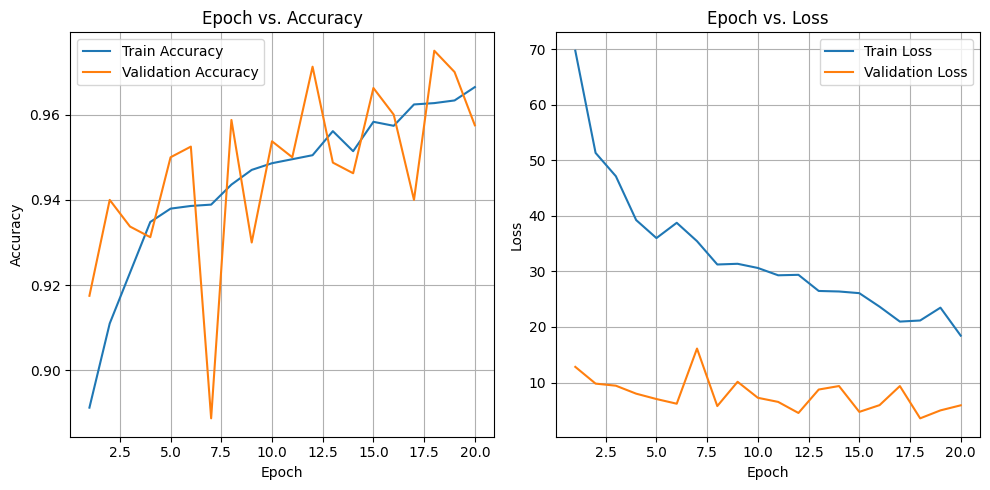

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(data['epoch'], data['train_acc'], label='Train Accuracy')
plt.plot(data['epoch'], data['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs. Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data['epoch'], data['train_loss'], label='Train Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs. Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
d1=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test_metrics_normal.csv")

In [ ]:
#appending batch to the csv file
d1['batch'] = range(len(d1))

In [ ]:
d1.head()

,Loss,Accuracy,Precision,Recall,F1,batch
0,0.361698,0.9375,0.500000,0.468750,0.483871,0
1,0.925782,0.8125,0.333333,0.270833,0.298851,1
2,0.432742,0.8750,0.500000,0.437500,0.466667,2
3,0.007620,1.0000,1.000000,1.000000,1.000000,3
4,0.000300,1.0000,1.000000,1.000000,1.000000,4


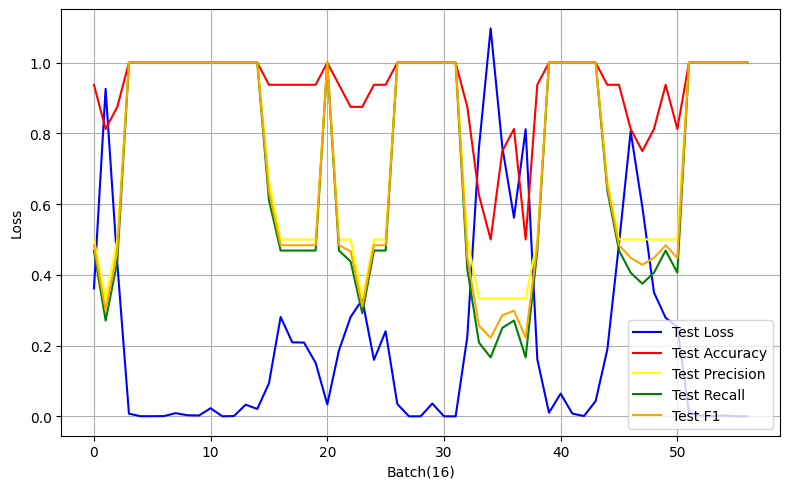

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(d1['batch'], d1['Loss'], label='Test Loss', color='blue')
plt.plot(d1['batch'], d1['Accuracy'], label='Test Accuracy', color='red')
plt.plot(d1['batch'], d1['Precision'], label='Test Precision', color='yellow')
plt.plot(d1['batch'], d1['Recall'], label='Test Recall', color='green')
plt.plot(d1['batch'], d1['F1'], label='Test F1', color='orange')
plt.xlabel('Batch(16)')
plt.ylabel('Loss')
#plt.title('Batch=16 vs. Test Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()